In [1]:
!ls data/*/*.csv

data/McGill-Billboard/billboard-2.0-index.csv


In [2]:
import pandas as pd
df = pd.read_csv('data/McGill-Billboard/billboard-2.0-index.csv')
df.head()

,id,chart_date,target_rank,actual_rank,title,artist,peak_rank,weeks_on_chart
0,1,1987-07-11,82,NaN,NaN,NaN,NaN,NaN
1,2,1973-08-04,14,NaN,NaN,NaN,NaN,NaN
2,3,1961-07-03,56,57.0,I Don't Mind,James Brown,47.0,8.0
3,4,1971-08-07,32,31.0,You've Got A Friend,"Roberta Flack,Donny Hathaway",29.0,12.0
4,5,1976-07-10,51,NaN,NaN,NaN,NaN,NaN


In [29]:
# check date range of songs
years = pd.DatetimeIndex(df.chart_date).year
print(f'{years.min()}-{years.max()}')

1958-1991


In [3]:
# for our application we're only interested in ID, title, and artist
df_songs = df[df.title.notnull() & df.artist.notnull()][['id', 'title', 'artist']]
df_songs.head()

,id,title,artist
2,3,I Don't Mind,James Brown
3,4,You've Got A Friend,"Roberta Flack,Donny Hathaway"
5,6,The Rose,Bette Midler
9,10,An Innocent Man,Billy Joel
11,12,Lookin' For Love,Johnny Lee


In [18]:
# check duplicates
dups = df_songs[df_songs.duplicated(subset=['title','artist'], keep=False)]
dups.head()

,id,title,artist
3,4,You've Got A Friend,"Roberta Flack,Donny Hathaway"
5,6,The Rose,Bette Midler
15,16,She Bop,Cyndi Lauper
22,23,And She Was,Talking Heads
28,29,The Joker,Steve Miller Band


#### Check available features

In [4]:
base_dir = 'data/McGill-Billboard'
sample_dir = f'{base_dir}/0003'
!ls {sample_dir} -l

total 812
-rw-rw-r-- 1 cjbayron cjbayron 580969 Aug  2  2013 bothchroma.csv
-rw-rw-r-- 1 cjbayron cjbayron 221942 Aug  2  2013 echonest.json
-rw-r--r-- 1 cjbayron cjbayron   3877 Sep  9  2013 full.lab
-rw-r--r-- 1 cjbayron cjbayron   3877 Sep  9  2013 majmin7inv.lab
-rw-r--r-- 1 cjbayron cjbayron   3877 Sep  9  2013 majmin7.lab
-rw-r--r-- 1 cjbayron cjbayron   3877 Sep  9  2013 majmininv.lab
-rw-r--r-- 1 cjbayron cjbayron   3877 Sep  9  2013 majmin.lab
-rw-rw-r-- 1 cjbayron cjbayron     62 Aug  2  2013 tuning.csv


In [11]:
!cat {sample_dir}/tuning.csv

"/tmp/audio.wav",0.000000000,151.022585034,441.452,"441,5 Hz"


In [26]:
!cat {sample_dir}/majmin7.lab | head -n 5

0.0	7.3469387e-2	N
7.3469387e-2	1.51356009	N
1.51356009	1.8015782305999999	N
1.8015782305999999	3.529687074200001	A:min
3.529687074200001	5.257795917800002	A:min


In [27]:
!cat {sample_dir}/bothchroma.csv | head -n 5

"/tmp/audio.wav",0.000000000,0.198482,0,0,0.635556,0.741292,1.0043,0.81444,0.0292819,0.141189,0.80793,0.91015,0.823603,1.22066,0.0969013,0.197437,0.860228,1.16515,1.13561,0.42842,0.112475,1.49297,0.556156,0.562561,0.864485
,0.046439909,0.310882,0,0,0.693876,0.628553,1.08004,0.676368,0.0175979,0.140079,0.927873,0.663851,0.460197,1.16061,0.306418,0.39068,0.939165,1.05337,1.30823,0.32271,0.0675953,1.53804,0.566076,0.627636,0.904673
,0.092879818,0.404969,0,0.0372381,0.68277,0.59114,1.14683,0.575229,0.0146243,0.128743,0.968012,0.461634,0.260265,1.18625,0.357235,0.392881,0.924133,0.946938,1.36967,0.23419,0.0561735,1.42935,0.532472,0.686886,0.906338
,0.139319727,0.480218,0,0.00500218,0.435639,0.450297,1.21112,0.458671,0.00637153,0.102629,0.962884,0.301896,0.257244,1.08408,0.395586,0.323281,0.917475,0.679013,1.48532,0.186736,0.0244738,1.22717,0.529464,0.717978,1.05768
,0.185759637,0.539064,0.146614,0.0108908,0.444361,0.196939,1.29815,0.239054,0.0233052,0.20809,0.948395,0.0258015,0.341731,0.945

In [47]:
# check if duplicates are exact match
NUM_CHECKS = 5
for ix in dups.index[:NUM_CHECKS]:
    row = dups.loc[ix]
    ids = df_songs[(df_songs.title == row.title)
                   & (df_songs.artist == row.artist)].id.values
    
    ref_id = ids[0]
    dirname = f'{base_dir}/{ref_id:04d}'
    with open(f'{dirname}/tuning.csv', 'r') as f:
        ref_tuning = f.read()
    
    with open(f'{dirname}/majmin7.lab', 'r') as f:
        ref_chords = f.read()
        
    with open(f'{dirname}/bothchroma.csv', 'r') as f:
        ref_chroma = f.read()
    
    for _id in ids[1:]:
        dirname = f'{base_dir}/{_id:04d}'
        with open(f'{dirname}/tuning.csv', 'r') as f:
            tuning = f.read()
        
        with open(f'{dirname}/majmin7.lab', 'r') as f:
            chords = f.read()
        
        with open(f'{dirname}/bothchroma.csv', 'r') as f:
            chroma = f.read()
        
        print(f'{_id:04d} to {ref_id:04d} [tuning]: {ref_tuning == tuning}')
        print(f'{_id:04d} to {ref_id:04d} [chords]: {ref_chords == chords}')
        print(f'{_id:04d} to {ref_id:04d} [chroma]: {ref_chroma == chroma}')
        print()

1229 to 0004 [tuning]: True
1229 to 0004 [chords]: True
1229 to 0004 [chroma]: True

1271 to 0006 [tuning]: True
1271 to 0006 [chords]: True
1271 to 0006 [chroma]: True

1274 to 0016 [tuning]: True
1274 to 0016 [chords]: True
1274 to 0016 [chroma]: True

0870 to 0023 [tuning]: True
0870 to 0023 [chords]: True
0870 to 0023 [chroma]: True

0504 to 0029 [tuning]: True
0504 to 0029 [chords]: True
0504 to 0029 [chroma]: True



This builds the confidence that we can just remove duplicates.

In [5]:
# we remove duplicated songs (except first occurrence)
unique_filter = ~df_songs.duplicated(subset=['title','artist'], keep='first')
df_songs_unique = df_songs[unique_filter]
print(len(df_songs_unique))
df_songs_unique.head()

742


,id,title,artist
2,3,I Don't Mind,James Brown
3,4,You've Got A Friend,"Roberta Flack,Donny Hathaway"
5,6,The Rose,Bette Midler
9,10,An Innocent Man,Billy Joel
11,12,Lookin' For Love,Johnny Lee


In [6]:
# check again
any(df_songs_unique.duplicated(subset=['title', 'artist']))

False

In [8]:
df_songs_unique.to_csv(f'{base_dir}/billboard-2.0-unique.csv', index=False)

#### Pick songs for feature analysis

In [1]:
import pandas as pd
base_dir = 'data/McGill-Billboard'
data_index = 'billboard-2.0-unique.csv'

df_songs_unique = pd.read_csv(f'{base_dir}/{data_index}')
df_songs_unique.head()

,id,title,artist
0,3,I Don't Mind,James Brown
1,4,You've Got A Friend,"Roberta Flack,Donny Hathaway"
2,6,The Rose,Bette Midler
3,10,An Innocent Man,Billy Joel
4,12,Lookin' For Love,Johnny Lee


In [95]:
df_songs_unique[df_songs_unique.title.str.contains("kiss", case=False)]

,id,title,artist
7,18,Kiss On My List,Daryl Hall & John Oates
31,54,Last Kiss,J. Frank Wilson & The Cavaliers
171,263,Last Kiss,Wednesday
238,370,Kisses On The Wind,Neneh Cherry
302,478,One Last Kiss,The J. Geils Band
511,856,I Like The Way (The Kissing Game),Hi-Five


In [94]:
df_songs_unique.artist.sample(n=10)

124         The O'Jays
436         Commodores
605    Aretha Franklin
621               Dion
270    George Harrison
4           Johnny Lee
493       Bill Withers
338        The Trammps
363              Queen
557             Boston
Name: artist, dtype: object

In [2]:
# after going around the list, picked the following:

# - 1289 - There She Goes - The La's
# - 736 - Do I Do - Stevie Wonder
# - 637 - Human Nature - Michael Jackson
# - 270 - In My Room - The Beach Boys
# - 18 - Kiss On My List - Daryl Hall & John Oates

picked_ids = [1289, 736, 637, 270, 18]

We download these songs to analyse if we can extract chroma features closely similar to those provided by dataset.

#### Chroma feature analysis

In [3]:
def load_billboard_chroma(_id):
    """ Load bothchroma(bass-treble) vectors from Billboard dataset """
    
    fn = f'{base_dir}/{_id:04d}/bothchroma.csv'
    contents = pd.read_csv(fn, header=None)
    
    # we only get 3rd column onwards
    # (first column empty, 2nd column time tick)
    bothchroma = contents[contents.columns[2:]].values
    return bothchroma
    
chroma_samp = load_billboard_chroma(1289)
chroma_samp.shape

(3498, 24)

In [53]:
from scipy.signal import resample
import librosa
import vamp
import torch
from torchaudio.transforms import Resample

_SAMPLE_RATE = 44100
def generate_chroma(_id, resampler='scipy', params={}):
    """ Generate chroma from raw audio """
    
    audio_fn = f'data/audio/{_id}/audio.wav'
    X, fs = librosa.load(audio_fn)
    if fs != _SAMPLE_RATE:
        if resampler == 'scipy':
            X = resample(X, num=int(len(X)*_SAMPLE_RATE/fs))
        elif resampler == 'torch':
            resampling_transform = Resample(orig_freq=fs,
                                            new_freq=_SAMPLE_RATE)
            X = resampling_transform(torch.Tensor([X])).squeeze().numpy()
        else: # add TF resampler
            raise Exception('unsupported resampler')
    
    out = vamp.collect(X, _SAMPLE_RATE, 'nnls-chroma:nnls-chroma',
                       output='bothchroma', parameters=params)
    chroma = out['matrix'][1]
    return chroma

chroma_gen = generate_chroma(1289)
chroma_gen.shape

chroma_gen = generate_chroma(1289, resampler='torch')
chroma_gen.shape

(3495, 24)

In [54]:
from librosa.sequence import dtw

print('**Feature comparison scores: (lower, better)**')
for _id in picked_ids:
    print(df_songs_unique[df_songs_unique.id == _id].iloc[0].title)
    chroma_samp = load_billboard_chroma(_id)
    chroma_gen = generate_chroma(_id)
    D, wp = dtw(chroma_samp.T, chroma_gen.T, subseq=True)
    print(f'- default params: {D[-1, -1]}')
          
    chroma_gen = generate_chroma(_id, params={'rollon': 1.0})
    D, wp = dtw(chroma_samp.T, chroma_gen.T, subseq=True)
    print(f'- rollon=1.0: {D[-1, -1]}')
    
    chroma_gen = generate_chroma(_id, resampler='torch')
    D, wp = dtw(chroma_samp.T, chroma_gen.T, subseq=True)
    print(f'- (torch) default params: {D[-1, -1]}')
          
    chroma_gen = generate_chroma(_id, resampler='torch', params={'rollon': 1.0})
    D, wp = dtw(chroma_samp.T, chroma_gen.T, subseq=True)
    print(f'- (torch) rollon=1.0: {D[-1, -1]}')
    
    break

**Feature comparison scores: (lower, better)**
There She Goes
- default params: 2445.989656735837
- rollon=1.0: 1606.7576781851947
- (torch) default params: 2445.9894078380116
- (torch) rollon=1.0: 1606.7905254813022


In [13]:
D.shape, X.shape, Y.shape

((3495, 3498), (24, 3498), (24, 3495))

In [35]:
from scipy.spatial.distance import euclidean

In [38]:
D[-1, -1]

1606.7576781851947

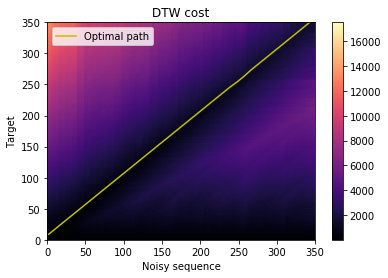

In [9]:
fig, ax = plt.subplots(nrows=1, sharex=True)
img = specshow(D[::10, ::10], x_axis='frames', y_axis='frames',
               ax=ax)

ax.set(title='DTW cost', xlabel='Noisy sequence', ylabel='Target')
ax.plot(wp[::10, 1], wp[::10, 0], label='Optimal path', color='y')
ax.legend()
fig.colorbar(img, ax=ax)

In [3]:
for _id in picked_ids[:1]:
    dirname = f'{base_dir}/{_id:04d}'
    #!cat {dirname}/tuning.csv
    
    audio_fn = f'data/audio/{_id}/audio.wav'
    print(audio_fn)
    

data/audio/1289/audio.wav


#### Scratch

In [8]:
!head {dirname}/bothchroma.csv

"/tmp/audio.wav",0.000000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0.046439909,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0.092879818,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0.139319727,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
,0.185759637,0,0,0,0,0,0,0,0,0,0,0,0,1.18229,0.415419,0.0468095,0.0618448,0.11878,1.71171,1.36705,0,0,0.272477,0.413524,0.179756
,0.232199546,0,0,0,0,0,0,0,0,0,0,0,0,0.975941,0.281009,0,0.0580218,0.0350331,3.12712,0.0937747,0,0,0.253713,0.529589,0.344651
,0.278639455,0,0,0,0,0,0,0,0,0,0,0,0,0.974944,0.165675,0,0.0555288,0,3.45902,0,0.00108475,0,0.299161,0.61126,0.333003
,0.325079365,0,0,0,0,0,0,0,0,0,0,0,0,0.984482,0.0991922,0,0.0518706,0,3.51712,0,0.00408833,0,0.332985,0.669024,0.297315
,0.371519274,0,0,0,0,0,0,0,0,0,0,0,0,1.01016,0.0540823,0,0.0449413,0,3.45042,0,0.00715798,0,0.386501,0.861106,0.214237
,0.417959183,0,0,0,0,0,0,0,0,0,0,0,0,0.980642,0.0275225,0,0.0331996,0,3.5245,0,0.0118653,0,0.415727,1.31184,0.134995


In [20]:
dirname

'data/McGill-Billboard/1289'

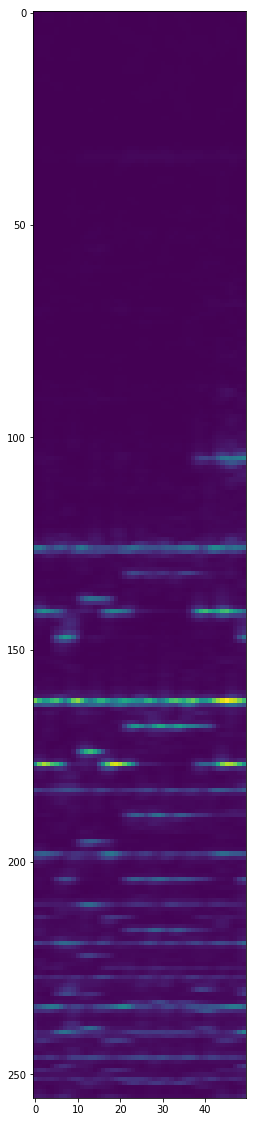

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,20))
plt.imshow(chroma['matrix'][1][0:50, :].T)
plt.show() # plot with corresponding names, investigate why 256 bins